In [1]:
from igraph import *
import networkx as nx
import random
import louvain
import os,sys
import time
import subprocess

/home/alphaq2/.local/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: This package has been superseded by the `leidenalg` package and will no longer be maintained. Please upgrade to the `leidenalg` package.
  after removing the cwd from sys.path.


In [2]:

def clique(g, size, idx, num_nodes):
  for i in range(idx,num_nodes-1):
    for j in range(idx - size,idx):
      g[i,j] = 0

In [3]:
def Print(g,num_nodes):
  G = nx.Graph()
  for i in range(num_nodes):
    G.add_node(i)
  for i in range(num_nodes):
    for j in range(i+1, num_nodes):
      if g[i,j] == 1:
        G.add_edge(i,j)
  nx.draw(G, with_labels=True)

In [4]:
def walktrap(g):
  k = g.community_walktrap()
  k = k.as_clustering()
  print(k)

In [5]:
def infomap(g):
  k = g.community_infomap()
  print(k)

In [6]:
def hub_node(clq):
    num_nodes = int((clq*(clq+1))/2) + 1
    g = Graph.Full(num_nodes)
    size = 0
    for i in range(clq,1,-1):
        size = size + i
        clique(g,i,size,num_nodes)
    walktrap(g)
    Print(g, num_nodes)
    infomap(g)

In [7]:
def hub_node2(clq):
    num_nodes = int(clq*(clq+1)) + 1
    g = Graph.Full(num_nodes)
    size = 0
    for i in range(clq,1,-1):
        size = size + i
        clique(g,i,size,num_nodes)
        size = size + i
        clique(g,i,size,num_nodes)
    g[num_nodes-2, num_nodes-3] = 0
    walktrap(g)
    Print(g, num_nodes)
    infomap(g)

In [8]:
def alt_hub_node(clq):
    num_nodes = int((clq+1)*(clq+1)/4) + 1
    g = Graph.Full(num_nodes)
    size = 0
    for i in range(clq,1,-2):
        size = size + i
        clique(g,i,size,num_nodes)
    walktrap(g)
    Print(g, num_nodes)
    infomap(g)

In [9]:
def creat_random_connected(offset,size,number_of_edges = 100000000):

    edges = []
    for i in range(size-1):
        edges.append((offset + i,offset + i + 1))
    edges.append((offset,offset + size - 1))
    ret_edges = edges[:];
    
    edges = []
    for i in range(size):
        for j in range(i + 1,size):
            if((offset + i,offset + j) not in ret_edges):
                edges.append((offset + i,offset + j))

    last = len(edges)-1
    for i in range(min(number_of_edges,len(edges))):
        ind = random.randint(0,last)
        ret_edges.append(edges[ind])
        tmp = edges[ind]
        edges[ind] = edges[last]
        edges[last] = tmp
        last -= 1
    return ret_edges

In [10]:
def ring_of_clique(ring_size , clique_size):

    total_vert = ring_size*clique_size;

    edges = creat_random_connected(0,clique_size);import random

    offset = clique_size
    prev_connector = offset - 1

    for i in range(ring_size - 1):
        new_clique = creat_random_connected(offset,clique_size);
        new_clique.append((prev_connector,offset))
        edges.extend(new_clique)
        offset += clique_size
        prev_connector += clique_size

    edges.append((0,prev_connector))

    return [total_vert, edges]


In [11]:
def line_star_graph(total_vert, line_length):
    edges = []

    for i in range(1,line_length):
        edges.append((i-1,i))

    middle_node = line_length//2
    rem_vert = total_vert - line_length
    offset = line_length

    for i in range(rem_vert):
        edges.append((middle_node,offset + i))

    return [total_vert, edges]

In [12]:
def run_louvain(total_vert,edges):
                
    g = Graph()
    g.add_vertices(total_vert)
    g.add_edges(edges)
    
#     Print(g,total_vert)
    
    part = louvain.find_partition(g, louvain.ModularityVertexPartition);
    print(part)

In [13]:
def run_maxperm(total_vert, edges):
    
    g = Graph()
    g.add_vertices(total_vert)
    g.add_edges(edges)
    
    input_file = open("input.dat", "w")
    input_file.write(str(total_vert) + " " + str(len(edges)) + "\n")
    for i in edges:
        m1 = i[0]
        m2 = i[1]
        input_file.write(str(m1) + " " + str(m2) + "\n")
#         input_file.write(str(m2) + " " + str(m1) + "\n")
    input_file.close()
    
    returned_value = subprocess.check_output("bash compile.sh", shell = True)
    returned_value = returned_value.decode("utf-8")
    
    print(returned_value)
    
    output_file = open("output.txt","r")
    partitions = output_file.readlines() 
#     print(partitions)
    partitions = partitions[2:]
    
    sets = {}
    for i in partitions:
        str1 = i[:-1].split("\t")
        node = int(str1[0])
        community = int(str1[1])
        if(community in sets):
            sets[community].append(node)
        else:
            sets[community] = [node]
    
    for i in sets.keys():
        print ("[" + str(i) + "] : "),
        print(sets[i])
    Print(g,total_vert)
    

In [14]:
def hub_surr_cliq(total_number_of_cliq,list_of_sizes):
    
    total_vert = sum(list_of_sizes) + 1
    offset = 1
    edges = []
    
    for i in range(total_number_of_cliq):
        edges.append((0,offset))
        edges.extend(creat_random_connected(offset,list_of_sizes[i]))
        offset += list_of_sizes[i]
    
    return [total_vert,edges]

In [15]:
def comm_surr_comm(middle_size,outer_size,count_outer):
    edges = []

    if(middle_size < count_outer):
        print "add more vertices to middle comm"
        return None

    g = Graph()
    total_vert = count_outer*outer_size + middle_size
    g.add_vertices(total_vert)

    edges.extend(creat_random_connected(0,middle_size))
    
    offset = middle_size
    for i in range(count_outer):
        edges.extend(creat_random_connected(offset,outer_size))
        edges.append((offset,i))
        offset += outer_size

    return [total_vert,edges]


In [16]:
def hub_node_graph(left_size,right_size):
    edges = []

#     g = Graph()
    total_vert = left_size + right_size + 1
#     g.add_vertices(total_vert)
    
    hub_node = 0
    offset_right = left_size + 1
    
    edges.extend(creat_random_connected(0,left_size + 1))
    edges.extend(creat_random_connected(offset_right,right_size))

    for i in range(right_size):
        edges.append((0,offset_right + i));
#     print(edges)
#     g.add_edges(edges)
    return [total_vert, edges]


In [17]:
run_maxperm(4,[(0,1),(1,2),(2,3),(2,0)])

-2147483647.000000
SumQ -0.333333 :: iter 1
SumQ 2.333333 :: iter 2
SumQ 2.333333 :: iter 3
Our MaxPerm Implementation took 0.000053 seconds

[1] :  [0, 1, 2, 3]


In [18]:
run_louvain(4,[(0,1),(1,2),(2,3),(2,0)])

Clustering with 4 elements and 2 clusters
[0] 0, 1
[1] 2, 3


LOUVAIN : 
Clustering with 100 elements and 3 clusters
[0] 5, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
    28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
    46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
    64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
    82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99
[1] 0, 1, 2, 3, 4
[2] 6, 7, 8, 9



MAXPERM : 
-2147483647.000000
SumQ -4.489130 :: iter 1
SumQ -2.021739 :: iter 2
SumQ -2.021739 :: iter 3
Our MaxPerm Implementation took 0.034361 seconds

[1] :  [0, 1, 2, 3, 4]
[10] :  [5, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 9

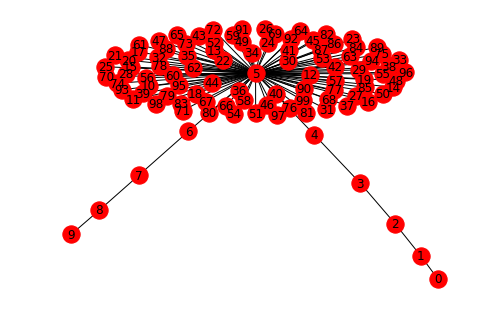

In [19]:
graph_1 = line_star_graph(100,10)
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

LOUVAIN : 
Clustering with 126 elements and 2 clusters
[0] 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
    22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
    40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
    58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
    76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93,
    94, 95, 96, 97, 98, 99, 100
[1] 0, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
    115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125



MAXPERM : 
-2147483647.000000
SumQ 58.050000 :: iter 1
SumQ 124.900000 :: iter 2
SumQ 124.900000 :: iter 3
Our MaxPerm Implementation took 9.994877 seconds

[101] :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,

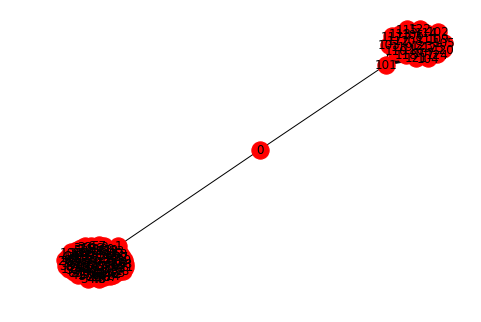

In [20]:
graph_1 = hub_surr_cliq(2,[100,25])
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

LOUVAIN : 
Clustering with 21 elements and 2 clusters
[0] 0, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20
[1] 1, 2, 3, 4, 5, 6, 7, 8, 9, 10



MAXPERM : 
-2147483647.000000
SumQ 5.700000 :: iter 1
SumQ 19.600000 :: iter 2
SumQ 19.600000 :: iter 3
Our MaxPerm Implementation took 0.000645 seconds

[1] :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


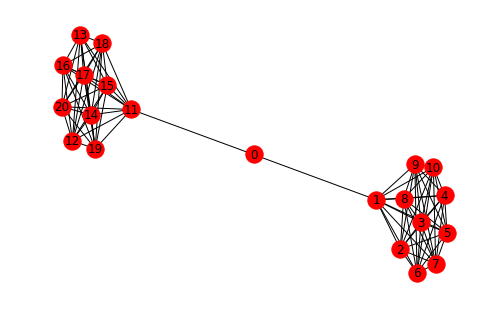

In [21]:
graph_1 = hub_surr_cliq(2,[10,10])
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

LOUVAIN : 
Clustering with 61 elements and 2 clusters
[0] 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
    29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
    47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60
[1] 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10



MAXPERM : 
-2147483647.000000
SumQ 25.620000 :: iter 1
SumQ 59.760000 :: iter 2
SumQ 59.760000 :: iter 3
Our MaxPerm Implementation took 0.293628 seconds

[1] :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]


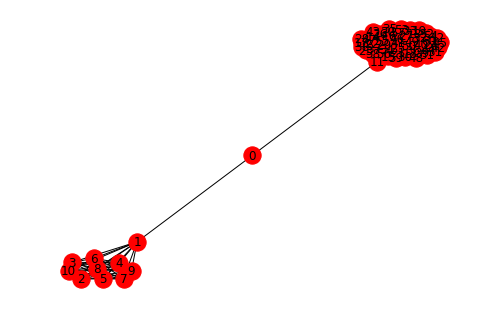

In [22]:
graph_1 = hub_surr_cliq(2,[10,50])
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

LOUVAIN : 
Clustering with 101 elements and 2 clusters
[0] 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
    21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
    39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50
[1] 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
    69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86,
    87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100



MAXPERM : 
-2147483647.000000
SumQ 45.540000 :: iter 1
SumQ 99.920000 :: iter 2
SumQ 99.920000 :: iter 3
Our MaxPerm Implementation took 0.708313 seconds

[1] :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 

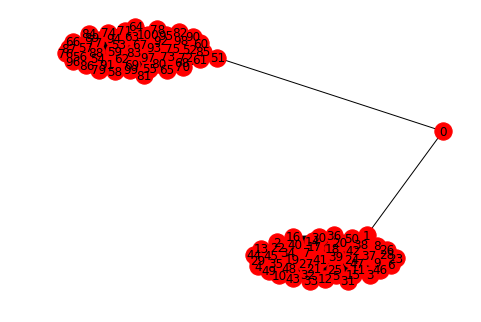

In [23]:
graph_1 = hub_surr_cliq(2,[50,50])
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

LOUVAIN : 
Clustering with 25 elements and 5 clusters
[0] 0, 1, 2, 3, 4
[1] 5, 6, 7, 8, 9
[2] 10, 11, 12, 13, 14
[3] 15, 16, 17, 18, 19
[4] 20, 21, 22, 23, 24



MAXPERM : 
-2147483647.000000
SumQ -6.000000 :: iter 1
SumQ 23.000000 :: iter 2
SumQ 23.000000 :: iter 3
Our MaxPerm Implementation took 0.000266 seconds

[17] :  [15, 16, 17, 18, 19]
[2] :  [0, 1, 2, 3, 4]
[12] :  [10, 11, 12, 13, 14]
[22] :  [20, 21, 22, 23, 24]
[7] :  [5, 6, 7, 8, 9]


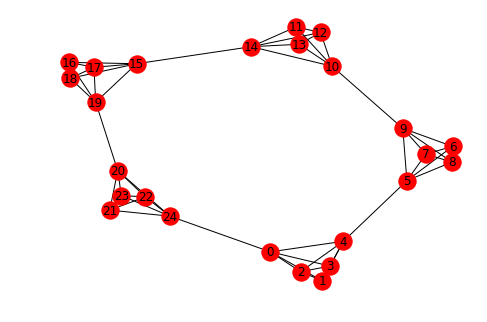

In [24]:
graph_1 = ring_of_clique(5,5)
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

LOUVAIN : 
Clustering with 30 elements and 3 clusters
[0] 0, 1, 2, 3, 4, 5, 6, 7, 8, 9
[1] 10, 11, 12, 13, 14, 15, 16, 17, 18, 19
[2] 20, 21, 22, 23, 24, 25, 26, 27, 28, 29



MAXPERM : 
-2147483647.000000
SumQ 3.366667 :: iter 1
SumQ 29.400000 :: iter 2
SumQ 29.400000 :: iter 3
Our MaxPerm Implementation took 0.002045 seconds

[2] :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[12] :  [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[22] :  [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


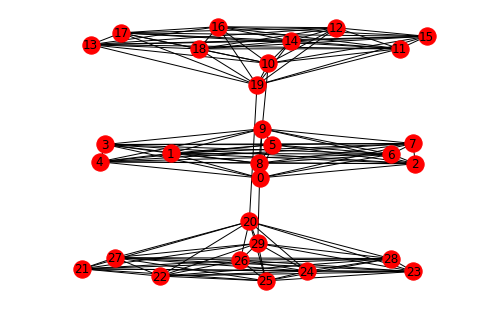

In [25]:
graph_1 = ring_of_clique(3,10)
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

LOUVAIN : 
Clustering with 30 elements and 3 clusters
[0] 0, 1, 2, 3, 4, 5, 6, 7, 8, 9
[1] 10, 11, 12, 13, 14, 15, 16, 17, 18, 19
[2] 20, 21, 22, 23, 24, 25, 26, 27, 28, 29



MAXPERM : 
-2147483647.000000
SumQ 3.366667 :: iter 1
SumQ 29.400000 :: iter 2
SumQ 29.400000 :: iter 3
Our MaxPerm Implementation took 0.000996 seconds

[2] :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[12] :  [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[22] :  [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


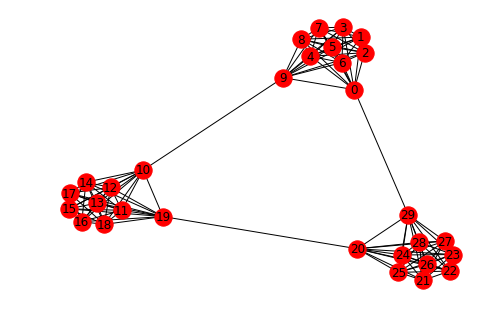

In [26]:
graph_1 = ring_of_clique(3,10)
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

LOUVAIN : 
Clustering with 50 elements and 11 clusters
[ 0] 0, 1, 2, 3, 4, 5, 6, 7, 8, 9
[ 1] 10, 11, 12, 13
[ 2] 14, 15, 16, 17
[ 3] 18, 19, 20, 21
[ 4] 22, 23, 24, 25
[ 5] 26, 27, 28, 29
[ 6] 30, 31, 32, 33
[ 7] 34, 35, 36, 37
[ 8] 38, 39, 40, 41
[ 9] 42, 43, 44, 45
[10] 46, 47, 48, 49



MAXPERM : 
-2147483647.000000
SumQ -23.166667 :: iter 1
SumQ 40.100000 :: iter 2
SumQ 46.500000 :: iter 3
SumQ 46.500000 :: iter 4
Our MaxPerm Implementation took 0.001528 seconds

[32] :  [30, 31, 32, 33]
[48] :  [46, 47, 48, 49]
[36] :  [34, 35, 36, 37]
[40] :  [38, 39, 40, 41]
[44] :  [42, 43, 44, 45]
[12] :  [10, 11, 12, 13]
[14] :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[16] :  [14, 15, 16, 17]
[20] :  [18, 19, 20, 21]
[24] :  [22, 23, 24, 25]
[28] :  [26, 27, 28, 29]


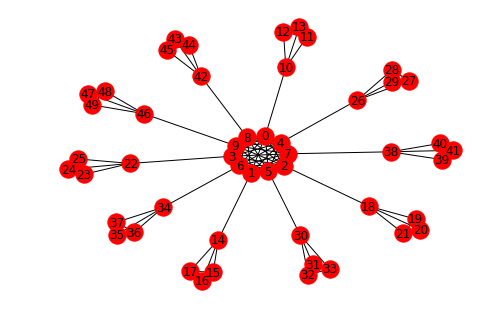

In [27]:
graph_1 = comm_surr_comm(10,4,10)
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

LOUVAIN : 
Clustering with 110 elements and 11 clusters
[ 0] 0, 1, 2, 3, 4, 5, 6, 7, 8, 9
[ 1] 10, 11, 12, 13, 14, 15, 16, 17, 18, 19
[ 2] 20, 21, 22, 23, 24, 25, 26, 27, 28, 29
[ 3] 30, 31, 32, 33, 34, 35, 36, 37, 38, 39
[ 4] 40, 41, 42, 43, 44, 45, 46, 47, 48, 49
[ 5] 50, 51, 52, 53, 54, 55, 56, 57, 58, 59
[ 6] 60, 61, 62, 63, 64, 65, 66, 67, 68, 69
[ 7] 70, 71, 72, 73, 74, 75, 76, 77, 78, 79
[ 8] 80, 81, 82, 83, 84, 85, 86, 87, 88, 89
[ 9] 90, 91, 92, 93, 94, 95, 96, 97, 98, 99
[10] 100, 101, 102, 103, 104, 105, 106, 107, 108, 109



MAXPERM : 
-2147483647.000000
SumQ 14.711111 :: iter 1
SumQ 108.000000 :: iter 2
SumQ 108.000000 :: iter 3
Our MaxPerm Implementation took 0.004729 seconds

[32] :  [30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
[1] :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[102] :  [100, 101, 102, 103, 104, 105, 106, 107, 108, 109]
[72] :  [70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
[42] :  [40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
[12] :  [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[82] :

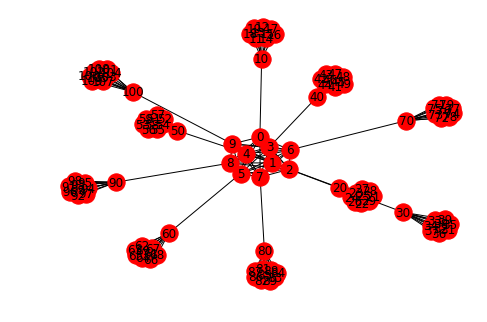

In [28]:
graph_1 = comm_surr_comm(10,10,10)
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

LOUVAIN : 
Clustering with 44 elements and 5 clusters
[0] 4, 5, 6, 7, 8, 9, 10, 11, 12, 13
[1] 14, 15, 16, 17, 18, 19, 20, 21, 22, 23
[2] 24, 25, 26, 27, 28, 29, 30, 31, 32, 33
[3] 34, 35, 36, 37, 38, 39, 40, 41, 42, 43
[4] 0, 1, 2, 3



MAXPERM : 
-2147483647.000000
SumQ 4.594444 :: iter 1
SumQ 42.600000 :: iter 2
SumQ 42.600000 :: iter 3
Our MaxPerm Implementation took 0.001691 seconds

[16] :  [14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
[1] :  [0, 1, 2, 3]
[26] :  [24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
[36] :  [34, 35, 36, 37, 38, 39, 40, 41, 42, 43]
[6] :  [4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


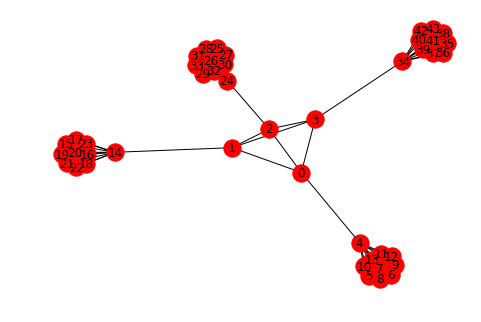

In [29]:
graph_1 = comm_surr_comm(4,10,4)
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

LOUVAIN : 
Clustering with 404 elements and 5 clusters
[0] 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
    24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,
    42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
    60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
    78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95,
    96, 97, 98, 99, 100, 101, 102, 103
[1] 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
    119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
    134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148,
    149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163,
    164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178,
    179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193,
    194, 195, 196, 197, 198, 199, 200, 201, 202, 2

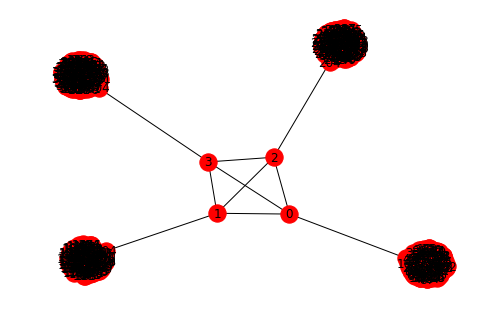

In [30]:
graph_1 = comm_surr_comm(4,100,4)
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

LOUVAIN : 
Clustering with 116 elements and 5 clusters
[0] 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
    24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,
    42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
    60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
    78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95,
    96, 97, 98, 99
[1] 0, 100, 101, 102, 103
[2] 1, 104, 105, 106, 107
[3] 2, 108, 109, 110, 111
[4] 3, 112, 113, 114, 115



MAXPERM : 
-2147483647.000000
SumQ 36.403636 :: iter 1
SumQ 114.900000 :: iter 2
SumQ 114.960000 :: iter 3
SumQ 114.960000 :: iter 4
Our MaxPerm Implementation took 12.382492 seconds

[106] :  [104, 105, 106, 107]
[114] :  [112, 113, 114, 115]
[100] :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 4

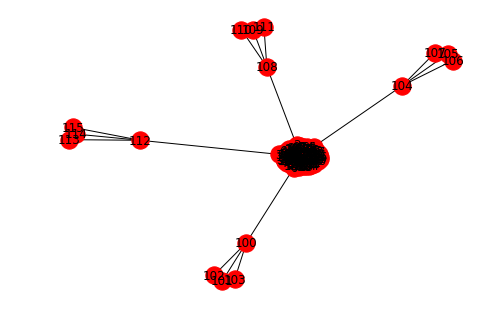

In [31]:
graph_1 = comm_surr_comm(100,4,4)
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

LOUVAIN : 
Clustering with 121 elements and 2 clusters
[0] 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
    22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
    40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
    58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
    76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93,
    94, 95, 96, 97, 98, 99, 100
[1] 0, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
    115, 116, 117, 118, 119, 120



MAXPERM : 
-2147483647.000000
SumQ 58.008333 :: iter 1
SumQ 120.719888 :: iter 2
SumQ 120.719888 :: iter 3
Our MaxPerm Implementation took 11.889962 seconds

[101] :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,

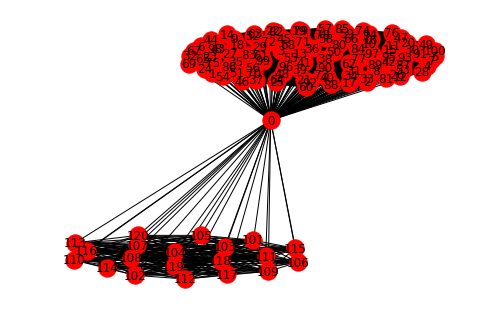

In [32]:
graph_1 = hub_node_graph(100,20)
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

LOUVAIN : 
Clustering with 10 elements and 2 clusters
[0] 0, 1, 2, 3, 4
[1] 5, 6, 7, 8, 9



MAXPERM : 
-2147483647.000000
SumQ -0.938889 :: iter 1
SumQ 8.138889 :: iter 2
SumQ 8.138889 :: iter 3
Our MaxPerm Implementation took 0.000146 seconds

[2] :  [1, 2, 3, 4]
[6] :  [0, 5, 6, 7, 8, 9]


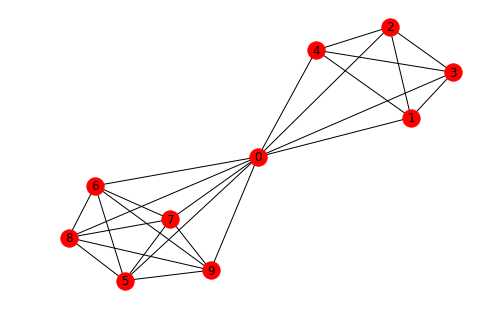

In [33]:
graph_1 = hub_node_graph(4,5)
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

LOUVAIN : 
Clustering with 111 elements and 2 clusters
[0] 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
    29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
    47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
    65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82,
    83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100,
    101, 102, 103, 104, 105, 106, 107, 108, 109, 110
[1] 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10



MAXPERM : 
-2147483647.000000
SumQ 50.610000 :: iter 1
SumQ 109.780000 :: iter 2
SumQ 109.780000 :: iter 3
Our MaxPerm Implementation took 10.782960 seconds

[1] :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78,

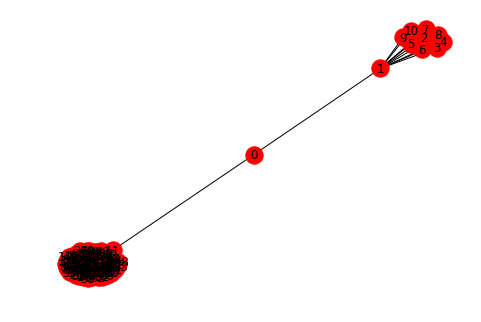

In [35]:
graph_1 = hub_surr_cliq(2,[10,100])
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

LOUVAIN : 
Clustering with 21 elements and 2 clusters
[0] 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10
[1] 11, 12, 13, 14, 15, 16, 17, 18, 19, 20



MAXPERM : 
-2147483647.000000
SumQ 5.700000 :: iter 1
SumQ 19.600000 :: iter 2
SumQ 19.600000 :: iter 3
Our MaxPerm Implementation took 0.000699 seconds

[1] :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


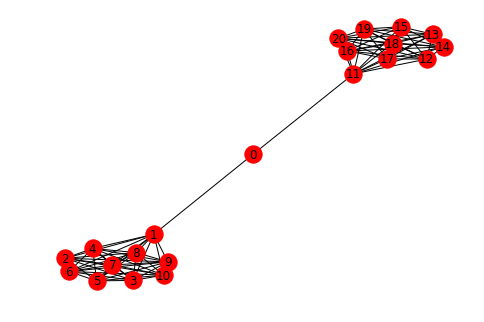

In [36]:
graph_1 = hub_surr_cliq(2,[10,10])
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

LOUVAIN : 
Clustering with 15 elements and 2 clusters
[0] 5, 6, 7, 8, 9, 10, 11, 12, 13, 14
[1] 0, 1, 2, 3, 4



MAXPERM : 
-2147483647.000000
SumQ 2.850000 :: iter 1
SumQ 13.300000 :: iter 2
SumQ 13.300000 :: iter 3
Our MaxPerm Implementation took 0.000442 seconds

[1] :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


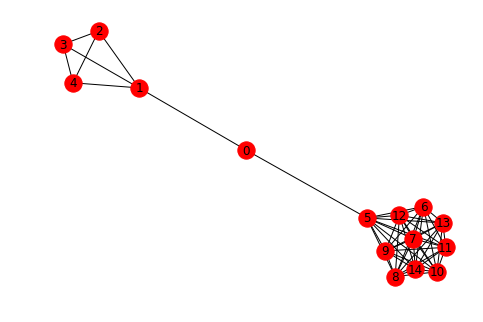

In [37]:
graph_1 = hub_surr_cliq(2,[4,10])
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

LOUVAIN : 
Clustering with 8 elements and 2 clusters
[0] 0, 1, 2, 3
[1] 4, 5, 6, 7



MAXPERM : 
-2147483647.000000
SumQ -0.416667 :: iter 1
SumQ 5.833333 :: iter 2
SumQ 5.833333 :: iter 3
Our MaxPerm Implementation took 0.000091 seconds

[1] :  [0, 1, 2, 3, 4, 5, 6, 7]


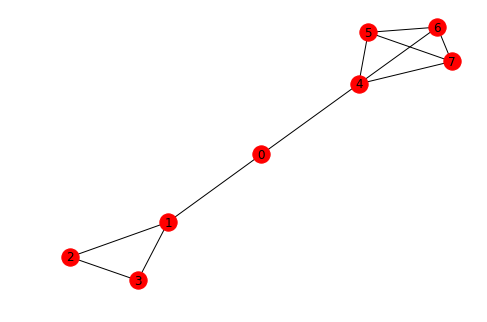

In [38]:
graph_1 = hub_surr_cliq(2,[3,4])
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

LOUVAIN : 
Clustering with 104 elements and 2 clusters
[0] 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
    25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,
    43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
    61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78,
    79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96,
    97, 98, 99, 100, 101, 102, 103
[1] 0, 1, 2, 3, 4



MAXPERM : 
-2147483647.000000
SumQ 47.343333 :: iter 1
SumQ 102.313333 :: iter 2
SumQ 102.313333 :: iter 3
Our MaxPerm Implementation took 14.209057 seconds

[1] :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87

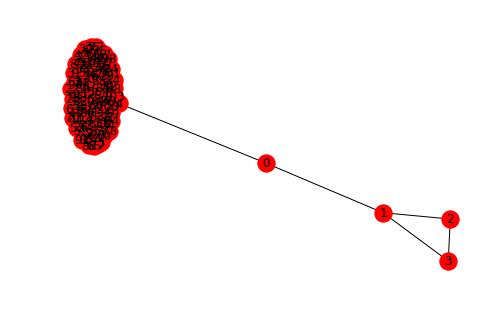

In [39]:
graph_1 = hub_surr_cliq(2,[3,100])
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

LOUVAIN : 
Clustering with 1000 elements and 56 clusters
[ 0] 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19
[ 1] 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
     38, 39
[ 2] 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
     58, 59
[ 3] 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
     78, 79
[ 4] 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,
     98, 99
[ 5] 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
     114, 115, 116, 117, 118, 119
[ 6] 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
     144, 145, 146, 147, 148, 149
[ 7] 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163,
     164, 165, 166, 167, 168, 169
[ 8] 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
     184, 185, 186, 187, 188, 189
[ 9] 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203,
  

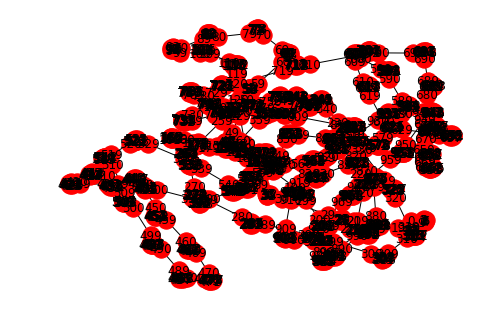

In [40]:
graph_1 = ring_of_clique(100,10)
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])